In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models, Model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import random
import time

In [92]:
activation_functions = {
    'tanh': tf.tanh,
    'relu': tf.nn.relu,
    'sigmoid': tf.nn.sigmoid,
    'linear': tf.keras.activations.linear,
}

**Loading Data**

In [93]:
%%time

# numpy
_, (X_test, y_test) = mnist.load_data() # only care  about X_test

X_test = X_test.reshape(10000, 784).astype(np.float32) / 255.0
y_test = to_categorical(y_test)  # one-hot encoding

# tensorflow
X_test = tf.convert_to_tensor(np.transpose(X_test))
y_test = tf.convert_to_tensor(np.transpose(y_test))

CPU times: total: 234 ms
Wall time: 233 ms


**Network Definition**

In [94]:
MUTATE_RATE_MATRIX = 0.3
MUTATE_RATE_BIAS = 0.1
MUTATE_RATE_ACTIVATION_FUNCTION = 0.1
GAUSSIAN_NOISE_STDDEV = 1   # mutation applies additive gaussian noise
UNIFORM_CROSSOVER = False   # if True, performs crossover of matrices element-wise, else row-wise

In [95]:
class MultiLayerPerceptron(Model):
    def __init__(self, **params):
        """
        Weight gnostic multi-layer feed forward neural network
        :param params: Params have to be in form: (matrix1=..., bias1=..., activations1=..., matrix2=..., ...)
        """
        super(MultiLayerPerceptron, self).__init__()

        self.n_layers = max([int(param_name[-1]) for param_name in params.keys()])   # = number of hidden layers + 1 (output layer)

        for (param_name, param) in params.items():
            assert param_name[:-1] in ('matrix', 'bias', 'activations'), 'Invalid attribute!'
            if 'activations' in param_name:
                setattr(self, param_name, [activation_functions[function] for function \
                                           in param])
            else:
                setattr(self, param_name, param)

    def call(self, inputs):
        x = inputs

        for layer in range(1, self.n_layers + 1):
            x = getattr(self, 'matrix' + str(layer)) @ x
            x += getattr(self, 'bias' + str(layer))

            activations = getattr(self, 'activations' + str(layer))
            indices = tf.range(x.shape[0])
            x, _ = tf.map_fn(fn=lambda t: (activations[t[0]](t[1]), 0),
                             elems=(indices, x), dtype=(tf.float32, tf.float32))

        return x

    # TODO: without custom function?
    def evaluate(self):
        y_pred = np.argmax(self.call(X_test), axis=0)
        y_true = np.argmax(y_test, axis=0)
        return np.mean(y_pred == y_true)

    def mutate(self):
        for layer in range(1, self.n_layers + 1):
            # matrix
            matrix = getattr(self, 'matrix' + str(layer))
            mutation_stencil = tf.cast(tf.reshape(tf.random.categorical(
                tf.math.log([[1 - MUTATE_RATE_MATRIX, MUTATE_RATE_MATRIX]]),
                matrix.shape[0] * matrix.shape[1]), matrix.shape), tf.float32)
            noise = tf.random.normal(mean=0.0, stddev=GAUSSIAN_NOISE_STDDEV, shape=matrix.shape)
            matrix = matrix + tf.multiply(mutation_stencil, noise)
            setattr(self, 'matrix' + str(layer), matrix)

            # bias
            bias = getattr(self, 'bias' + str(layer))
            mutation_stencil = tf.cast(tf.reshape(tf.random.categorical(
                tf.math.log([[1 - MUTATE_RATE_BIAS, MUTATE_RATE_BIAS]]),
                bias.shape[0]), bias.shape), tf.float32)
            noise = tf.random.normal(mean=0.0, stddev=GAUSSIAN_NOISE_STDDEV, shape=bias.shape)
            bias = bias + tf.multiply(mutation_stencil, noise)
            setattr(self, 'bias' + str(layer), bias)

            # activation
            activations = getattr(self, 'activations' + str(layer))
            activations = [function if (random.uniform(0, 1) < 0.5) else random.choice(list(activation_functions.values())) for function in activations]
            setattr(self, 'activations' + str(layer), activations)

    def summary(self):
        dash = '-' * 75
        ddash = '=' * 75
        print(dash)
        print('Model')
        print(ddash)

        n_params = 0
        for layer in range(1, self.n_layers + 1):
            # get values
            matrix = getattr(self, 'matrix' + str(layer))
            bias = getattr(self, 'bias' + str(layer))
            cleaner = lambda x: 'softmax' if x=='softmax_v2' else x
            activations = [cleaner(function.__name__) for function in getattr(self, 'activations' + str(layer))]

            n_params += matrix.shape[0] * matrix.shape[1] + bias.shape[0]

            # print adjustments
            activations = '({})'.format(activations)
            layer_IO = '(in={}, out={})'.format(matrix.shape[1], matrix.shape[0],)

            print('Linear {:<20}{:<30}#Params: {}'.format(activations, layer_IO, matrix.shape[0] * matrix.shape[1] + bias.shape[0]))

        print(ddash)
        print('Total params: {}'.format(n_params))
        print('Accuracy: {}'.format(self.evaluate()))

In [96]:
class Population:
    # TODO: n_layers evolvable
    def __init__(self, size=10, n_survivors=5, n_hidden_layers=1):
        """
        :param size: population size
        :param n_survivors: number of survivors after each generation (rest is killed and unable to pass on its genes)
        :param n_hidden_layers: number of hidden layers
        """
        self.generation = 0
        self.size = size
        self.n_survivors = n_survivors
        self.n_hidden_layers = n_hidden_layers
        self.elite = None
        self.fitness = None # cache fitness for increased speed
        self.fitness_generation = -1  # generation when fitness was evaluated

        # initialization (gaussian)
        # TODO: hidden layer width fixed for now
        self.organisms = []
        for _ in range(size):
            params = {}

            # first hidden layer
            params['matrix1'] = tf.random.normal(mean=0.0, stddev=1.0, shape=[32, 784])
            params['bias1'] = tf.random.normal(mean=0.0, stddev=1.0, shape=[32, 1])
            params['activations1'] = ['sigmoid']*32

            for hidden_layer in range(2, n_hidden_layers + 2):
                params['matrix' + str(hidden_layer)] = tf.random.normal(mean=0.0, stddev=1.0, shape=[32, 32])
                params['bias' + str(hidden_layer)] = tf.random.normal(mean=0.0, stddev=1.0, shape=[32, 1])
                params['activations' + str(hidden_layer)] = ['sigmoid']*32

            # output layer
            params['matrix' + str(self.n_hidden_layers + 1)] = tf.random.normal(mean=0.0, stddev=1.0, shape=[10, 32])
            params['bias' + str(self.n_hidden_layers + 1)] = tf.random.normal(mean=0.0, stddev=1.0, shape=[10, 1])
            params['activations' + str(self.n_hidden_layers + 1)] = ['sigmoid']*10

            model = MultiLayerPerceptron(**params)
            self.organisms.append(model)

        self.history = [(max(self.organism_fitness()), self.average_fitness())]   # fitness of population over all generations

    def organism_fitness(self):
        if self.generation != self.fitness_generation:
            self.fitness = [organism.evaluate() for organism in self.organisms]
            self.fitness_generation = self.generation

        return self.fitness

    def average_fitness(self):
        organism_fitness = self.organism_fitness()
        return sum(organism_fitness) / len(organism_fitness)

    def max_fitness(self):
        return max(self.organism_fitness())

    def selection(self):
        organism_fitness = self.organism_fitness()

        # elitism (n=1)
        elite_index = np.argmax(organism_fitness)
        self.elite = self.organisms.pop(elite_index)
        organism_fitness.pop(elite_index)

        probabilities = [fitness / sum(organism_fitness) for fitness in organism_fitness]  # normalized
        survivors = np.random.choice(self.organisms,
                                     size=self.n_survivors - 1,
                                     p=probabilities,
                                     replace=False)    # TODO: works without replacement and p?
        return [survivor for survivor in survivors]

    def crossover(self, parents):
        children = []
        while len(children) < (self.size - 1):
            [father, mother] = random.sample(parents + [self.elite], k=2)  # sample without replacement

            child_params = {}
            for layer in range(1, father.n_layers + 1):
                if UNIFORM_CROSSOVER:
                    # matrix - uniform crossover
                    father_matrix = getattr(father, 'matrix' + str(layer))
                    mother_matrix = getattr(mother, 'matrix' + str(layer))

                    father_mask = tf.round(tf.random.uniform(father_matrix.shape))
                    mother_mask = - (father_mask - 1)

                    child_matrix = tf.multiply(father_mask, father_matrix) + tf.multiply(mother_mask, mother_matrix)
                    child_params['matrix' + str(layer)] = child_matrix
                else:
                    # matrix - row wise (neuron wise) crossover
                    father_matrix = getattr(father, 'matrix' + str(layer))
                    mother_matrix = getattr(mother, 'matrix' + str(layer))

                    n_rows = father_matrix.shape[0]
                    father_mask = np.random.choice([True, False], size=n_rows)

                    child_matrix = tf.convert_to_tensor([father_matrix[row, :] if father_mask[row] \
                                                         else mother_matrix[row, :] for row in range(n_rows)])
                    child_params['matrix' + str(layer)] = child_matrix

                # bias - uniform crossover
                father_bias = getattr(father, 'bias' + str(layer))
                mother_bias = getattr(mother, 'bias' + str(layer))

                father_stencil = tf.round(tf.random.uniform(father_bias.shape))
                mother_stencil = - (father_stencil - 1)

                child_bias = tf.multiply(father_stencil, father_bias) + tf.multiply(mother_stencil, mother_bias)
                child_params['bias' + str(layer)] = child_bias

                # activation
                cleaner = lambda x: 'softmax' if x=='softmax_v2' else x
                father_activation = [cleaner(function.__name__) for function in getattr(father, 'activations' + str(layer))]
                mother_activation = [cleaner(function.__name__) for function in getattr(mother, 'activations' + str(layer))]

                child_activations = [function if (random.uniform(0, 1) < 0.5) else mother_activation[i] for i, function in enumerate(father_activation)]
                child_params['activations' + str(layer)] = child_activations

            model = MultiLayerPerceptron(**child_params)
            children.append(model)

        return children

    def mutate(self, organisms):
        for organism in organisms:
            organism.mutate()

    def breed(self):
        #time_debug = ''

        #t_a = time.time()
        parents = self.selection()
        #t_b = time.time()
        #time_debug += 'selection time: {}s - '.format(round(t_b - t_a, 4))

        #t_a = time.time()
        children = self.crossover(parents)
        #t_b = time.time()
        #time_debug += 'crossover time: {}s - '.format(round(t_b - t_a, 4))

        #t_a = time.time()
        self.mutate(children)  # TODO: mGA or GA?
        #t_b = time.time()
        #time_debug += 'mutation time: {}s - '.format(round(t_b - t_a, 4))

        #print(time_debug)

        self.organisms = children + [self.elite]
        self.generation += 1
        self.history.append((self.max_fitness(), self.average_fitness()))

    def plot(self):
        # plot evolution
        plt.figure()
        plt.plot(np.arange(self.generation + 1), [score[0] for score in self.history],
                 label='max fitness')
        plt.plot(np.arange(self.generation + 1), [score[1] for score in self.history],
                 label='avg fitness', alpha=0.6)
        plt.title('Population fitness' + ' (n=' + str(self.size) + ')')
        plt.xlabel('Generations')
        plt.ylabel('Fitness score (accuracy)')
        plt.legend()
        plt.show()

        # plot best performing final network
        organism_fitness = self.organism_fitness()
        elite_index = np.argmax(organism_fitness)
        self.organisms[elite_index].summary()

**Training**

In [97]:
# initialization
GENERATIONS = 400
POPULATION_SIZE = 30
SURVIVORS = 15
N_HIDDEN_LAYERS = 1

Starting training
Gen 0 : [0.1023, 0.1255, 0.1157, 0.1165, 0.1362, 0.0906, 0.1017, 0.0814, 0.1328, 0.1116, 0.0769, 0.1015, 0.1071, 0.1353, 0.1074, 0.0897, 0.0937, 0.1025, 0.1165, 0.0848, 0.1285, 0.113, 0.1111, 0.0897, 0.0892, 0.1097, 0.1355, 0.0926, 0.0857, 0.1502] - max: 0.1502 (1.25s)
Gen 1 : [0.1037, 0.1536, 0.145, 0.1304, 0.0977, 0.0661, 0.1232, 0.1015, 0.0786, 0.1027, 0.0866, 0.0893, 0.0912, 0.0647, 0.1034, 0.0758, 0.0856, 0.065, 0.0959, 0.1021, 0.0789, 0.1011, 0.0889, 0.1244, 0.0707, 0.1386, 0.0682, 0.0693, 0.1078, 0.1502] - max: 0.1536 (1.32s)
Gen 2 : [0.0822, 0.0762, 0.1242, 0.0936, 0.1085, 0.1007, 0.1055, 0.1217, 0.1225, 0.0703, 0.1021, 0.1224, 0.1031, 0.0952, 0.105, 0.1284, 0.0982, 0.099, 0.0837, 0.1011, 0.1029, 0.0984, 0.0898, 0.056, 0.0757, 0.1138, 0.0845, 0.1068, 0.0831, 0.1536] - max: 0.1536 (1.27s)
Gen 3 : [0.1172, 0.0804, 0.099, 0.0549, 0.1114, 0.0875, 0.151, 0.0824, 0.0941, 0.1051, 0.1016, 0.0857, 0.0993, 0.0975, 0.0801, 0.11, 0.1013, 0.1152, 0.1044, 0.1449, 0.1427, 0.

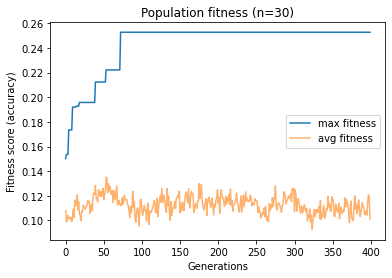

---------------------------------------------------------------------------
Model
Linear (['linear', 'sigmoid', 'tanh', 'tanh', 'linear', 'relu', 'linear', 'sigmoid', 'tanh', 'sigmoid', 'sigmoid', 'sigmoid', 'tanh', 'sigmoid', 'relu', 'linear', 'tanh', 'linear', 'sigmoid', 'tanh', 'linear', 'linear', 'linear', 'linear', 'sigmoid', 'linear', 'relu', 'linear', 'linear', 'linear', 'tanh', 'tanh'])(in=784, out=32)              #Params: 25120
Linear (['linear', 'relu', 'linear', 'relu', 'linear', 'sigmoid', 'relu', 'relu', 'sigmoid', 'tanh'])(in=32, out=10)               #Params: 330
Total params: 25450
Accuracy: 0.2528


In [98]:
# initial population
print('Starting training')
t_training = time.time()
population = Population(size=POPULATION_SIZE, n_survivors=SURVIVORS, n_hidden_layers=N_HIDDEN_LAYERS)
population_fitness = population.organism_fitness()
max_fitness = population.max_fitness()
t2 = time.time()
print('Gen', 0, ':',
      population_fitness, '- max:',
      max_fitness,
      '({}s)'.format(round(t2 - t_training, 2)))

# future populations
for generation in range(1, GENERATIONS):
    # breed new population
    t1 = time.time()
    population.breed()

    # evaluate new population
    population_fitness = population.organism_fitness()
    max_fitness = population.max_fitness()
    t2 = time.time()

    print('Gen', generation, ':',
          population_fitness, '- max:',
          max_fitness,
          '({}s)'.format(round(t2 - t1, 2)))

print('Finished training ({})'.format(round(time.time() - t_training, 2)))

# performance of population
population.plot()